In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import GridSearchCV,train_test_split,StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler ,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif ,SelectFromModel
from imblearn.pipeline import Pipeline  
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score , precision_score ,f1_score ,recall_score
from sklearn.ensemble import RandomForestClassifier ,GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.decomposition import PCA

In [3]:
df =pd.read_csv('cleaned_data.csv')

In [4]:
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
X=df.drop('diagnosis',axis=1)
y=df['diagnosis']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [7]:
log_reg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42)),
    ('pca',PCA()) ,
    ("classifier", LogisticRegression(max_iter=5000))  
])

log_reg_param_grid = [
    {
        "pca__n_components": [5, 10, 15, 20],
        "classifier__solver": ["liblinear"],
        "classifier__penalty": ["l1", "l2"],
        "classifier__C": [0.01, 0.1, 1, 10]
    },
    {   
        "pca__n_components": [5, 10, 15, 20],
        "classifier__solver": ["lbfgs", "newton-cg"],
        "classifier__penalty": ["l2"],
        "classifier__C": [0.01, 0.1, 1, 10]
    },
    {
        "pca__n_components": [5, 10, 15, 20],
        "classifier__solver": ["saga"],
        "classifier__penalty": ["l1", "l2"],
        "classifier__C": [0.01, 0.1, 1, 10]
    },
    {
        "pca__n_components": [5, 10, 15, 20],
        "classifier__solver": ["saga"],
        "classifier__penalty": ["elasticnet"],
        "classifier__l1_ratio": [0, 0.5, 1],
        "classifier__C": [0.01, 0.1, 1, 10]
    }
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search_log_reg = GridSearchCV(
    log_reg_pipeline,
    log_reg_param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
)

grid_search_log_reg.fit(X_train, y_train)
print("Best Logistic Regression Parameters:", grid_search_log_reg.best_params_)
print("Best Logistic Regression Score:", grid_search_log_reg.best_score_)


Best Logistic Regression Parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'pca__n_components': 10}
Best Logistic Regression Score: 0.9802197802197803



Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        72
           1       1.00      0.95      0.98        42

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



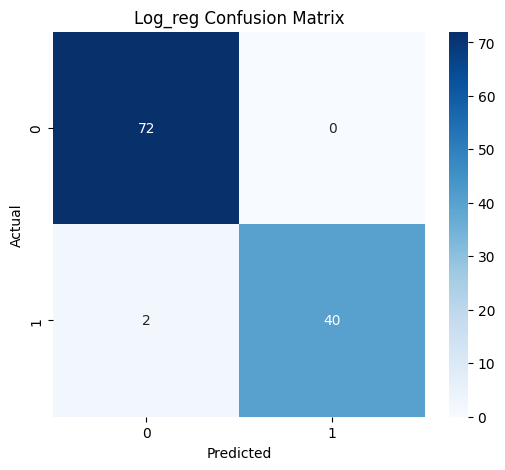

In [8]:
best_log=grid_search_log_reg.best_estimator_

y_pred = best_log.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Log_reg Confusion Matrix")
plt.show()

In [9]:
dt_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ('pca',PCA()) ,
    ("smote", SMOTE(random_state=42)),
    ("model", DecisionTreeClassifier(random_state=42))
])

param_grid_dt = {
    "pca__n_components": [5, 10, 15, 20],
    "model__criterion": ["gini", "entropy"],
    "model__max_depth": [None, 5, 10, 20],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 5]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_dt = GridSearchCV(dt_pipeline, param_grid_dt, cv=cv, scoring="accuracy")
grid_dt.fit(X_train, y_train)

print("Best Decision Tree Params:", grid_dt.best_params_)
print("Best Decision Tree Score:", grid_dt.best_score_)

Best Decision Tree Params: {'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 1, 'model__min_samples_split': 10, 'pca__n_components': 10}
Best Decision Tree Score: 0.945054945054945



Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97        72
           1       0.97      0.90      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



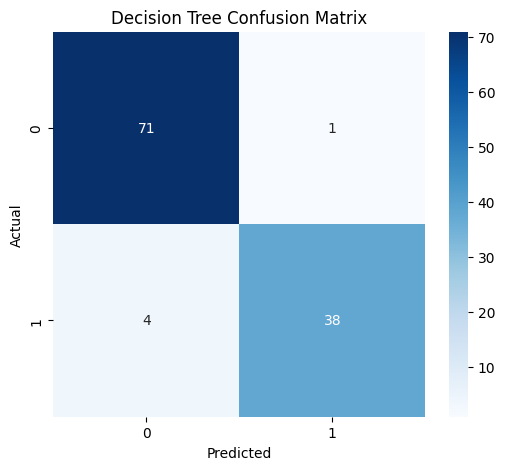

In [10]:
best_dt=grid_dt.best_estimator_

y_pred = best_dt.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Decision Tree Confusion Matrix")
plt.show()

In [11]:
rf_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ('pca',PCA()) ,
    ("smote", SMOTE(random_state=42)),
    ("model", RandomForestClassifier(random_state=42,n_jobs=-1))
])

param_grid_rf_tree = {
    "pca__n_components": [5, 10, 15, 20],
    "model__n_estimators": [100, 200],
    "model__max_depth": [None, 5, 10, 20],
    "model__max_features": ["sqrt", "log2", None],   
    "model__min_samples_leaf": [1, 2, 4, 6]  
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_rf_tree = GridSearchCV(rf_pipeline, param_grid_rf_tree, cv=cv, scoring="accuracy")
grid_rf_tree.fit(X_train, y_train)

print("Best Tree-based RF:", grid_rf_tree.best_params_)
print("Best Score:", grid_rf_tree.best_score_)

Best Tree-based RF: {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__n_estimators': 200, 'pca__n_components': 10}
Best Score: 0.9626373626373625



Accuracy = 0.956140350877193

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        72
           1       0.95      0.93      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



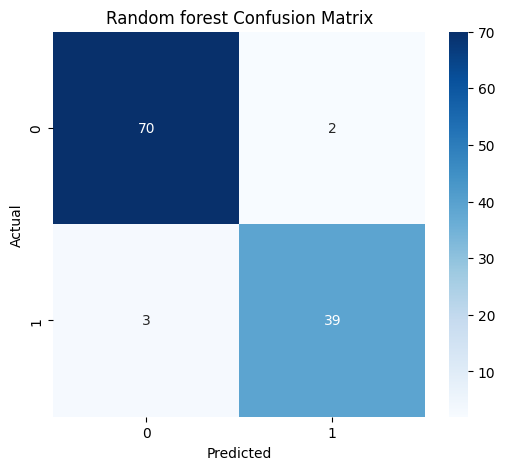

In [12]:
best_rf=grid_rf_tree.best_estimator_

y_pred = best_rf.predict(X_test)
print(f'\nAccuracy = {best_rf.score(X_test,y_test)}')
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random forest Confusion Matrix")
plt.show()

In [13]:
svm_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ('pca',PCA()) ,
    ("smote", SMOTE(random_state=42)),
    ("model", SVC(probability=True, random_state=42))])

svm_param_grid = {
    "pca__n_components": [5, 10, 15, 20],
    "model__kernel": ["linear", "rbf", "sigmoid"],
    "model__C": [0.1, 1, 10, 100, 1000],
    "model__gamma": ["scale", "auto", 0.001, 0.01, 0.1, 1]}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_svm = GridSearchCV(svm_pipeline,param_grid=svm_param_grid,cv=cv,scoring="accuracy",n_jobs=-1,verbose=2)

grid_svm.fit(X_train, y_train)

print("Best SVM Params:", grid_svm.best_params_)
print("Best CV Score:", grid_svm.best_score_)


Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best SVM Params: {'model__C': 10, 'model__gamma': 0.01, 'model__kernel': 'rbf', 'pca__n_components': 15}
Best CV Score: 0.9802197802197803



Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        72
           1       1.00      0.95      0.98        42

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



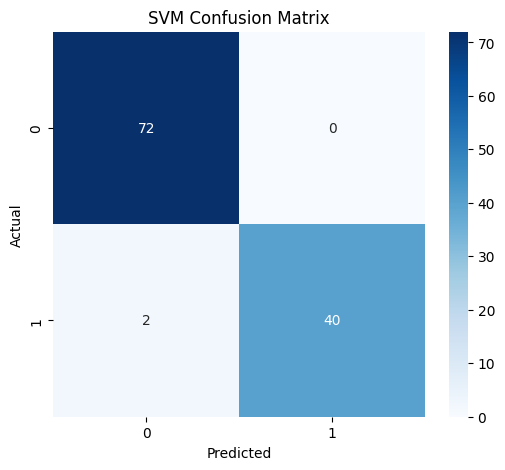

In [14]:
best_svm = grid_svm.best_estimator_

y_pred = best_svm.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SVM Confusion Matrix")
plt.show()


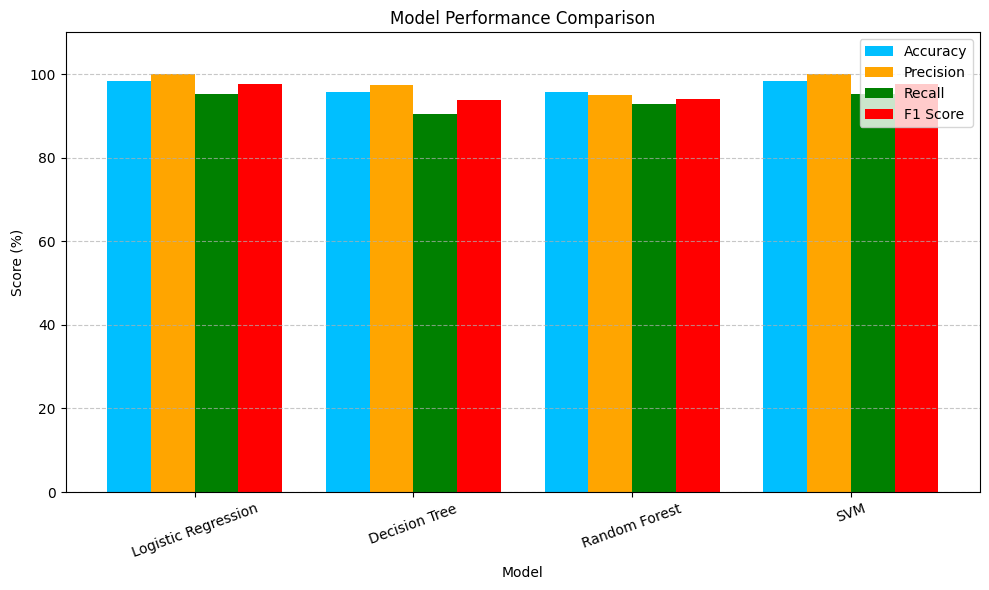

In [15]:

models = {
    'Logistic Regression': best_log,
    'Decision Tree': best_dt,
    'Random Forest': best_rf,
    'SVM': best_svm
}

accuracy = []
precision = []
recall = []
f1 = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred) * 100)
    precision.append(precision_score(y_test, y_pred, average='binary') * 100)
    recall.append(recall_score(y_test, y_pred, average='binary') * 100)
    f1.append(f1_score(y_test, y_pred, average='binary') * 100)

x = np.arange(len(models))
width = 0.2

plt.figure(figsize=(10, 6))
plt.bar(x - 1.5*width, accuracy, width, label='Accuracy', color='deepskyblue')
plt.bar(x - 0.5*width, precision, width, label='Precision', color='orange')
plt.bar(x + 0.5*width, recall, width, label='Recall', color='green')
plt.bar(x + 1.5*width, f1, width, label='F1 Score', color='red')

plt.xlabel('Model')
plt.ylabel('Score (%)')
plt.title('Model Performance Comparison')
plt.xticks(x, list(models.keys()), rotation=20)
plt.ylim(0, 110)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [20]:
from random import randint
import scipy.stats as stats

scores = []

for _ in range(10):
    seed = randint(0,1000)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=seed, stratify=y
    )
    best_log.fit(X_train, y_train)
    y_pred = best_log.predict(X_test)
    
    precision = precision_score(y_test, y_pred, average='binary')
    scores.append(precision)

mean_precision = np.mean(scores)
std_precision = np.std(scores, ddof=1)

confidence = 0.95
n = len(scores)
h = stats.t.ppf((1 + confidence) / 2, n - 1) * (std_precision / np.sqrt(n))
lower_bound = mean_precision - h
upper_bound = mean_precision + h

print(f"Mean Precision: {mean_precision:.4f}")
print(f"Standard Deviation: {std_precision:.4f}")
print(f"95% Confidence Interval: [{lower_bound:.4f}, {upper_bound:.4f}]")


Mean Precision: 0.9717
Standard Deviation: 0.0258
95% Confidence Interval: [0.9532, 0.9902]


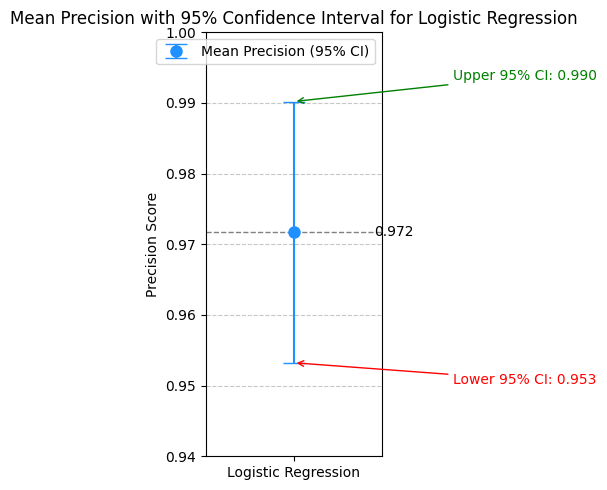

In [21]:
import scipy.stats as stats

mean_precision = np.mean(scores)
std_precision = np.std(scores, ddof=1)
confidence = 0.95
n = len(scores)
h = stats.t.ppf((1 + confidence) / 2, n - 1) * (std_precision / np.sqrt(n))
lower_bound = mean_precision - h
upper_bound = mean_precision + h

plt.figure(figsize=(6, 5))
plt.errorbar(
    x=1, y=mean_precision,
    yerr=h, fmt='o',
    color='dodgerblue', capsize=8, markersize=8, label='Mean Precision (95% CI)'
)
plt.axhline(mean_precision, color='gray', linestyle='--', linewidth=1)
plt.text(1.05, mean_precision, f"{mean_precision:.3f}", va='center')

plt.annotate(f"Lower 95% CI: {lower_bound:.3f}", xy=(1, lower_bound),
             xytext=(1.1, lower_bound - 0.003),
             arrowprops=dict(arrowstyle="->", color='red'),
             color='red', fontsize=10)

plt.annotate(f"Upper 95% CI: {upper_bound:.3f}", xy=(1, upper_bound),
             xytext=(1.1, upper_bound + 0.003),
             arrowprops=dict(arrowstyle="->", color='green'),
             color='green', fontsize=10)

plt.title("Mean Precision with 95% Confidence Interval for Logistic Regression")
plt.ylabel("Precision Score")
plt.xticks([1], ['Logistic Regression'])
plt.ylim(.94, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


In [18]:
import scipy.stats as stats
from random import randint


scores = []

for _ in range(10): 
    seed = randint(0,1000)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=seed, stratify=y
    )
    best_svm.fit(X_train, y_train)
    y_pred = best_svm.predict(X_test)
    
    precision = precision_score(y_test, y_pred, average='binary')
    scores.append(precision)

mean_precision = np.mean(scores)
std_precision = np.std(scores, ddof=1)

confidence = 0.95
n = len(scores)
h = stats.t.ppf((1 + confidence) / 2, n - 1) * (std_precision / np.sqrt(n))
lower_bound = mean_precision - h
upper_bound = mean_precision + h

print(f"Mean Precision: {mean_precision:.4f}")
print(f"Standard Deviation: {std_precision:.4f}")
print(f"95% Confidence Interval: [{lower_bound:.4f}, {upper_bound:.4f}]")


Mean Precision: 0.9671
Standard Deviation: 0.0335
95% Confidence Interval: [0.9431, 0.9910]


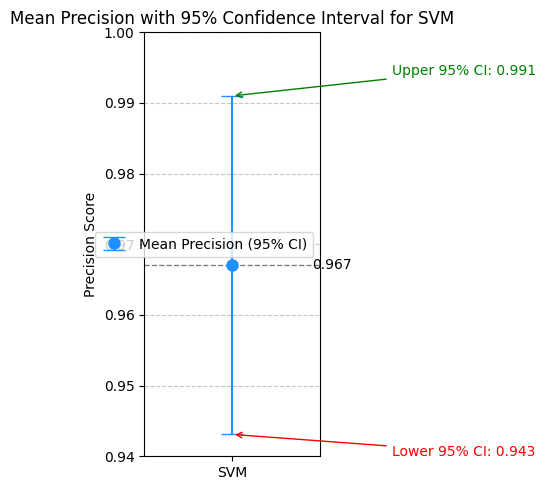

In [19]:
mean_precision = np.mean(scores)
std_precision = np.std(scores, ddof=1)
confidence = 0.95
n = len(scores)
h = stats.t.ppf((1 + confidence) / 2, n - 1) * (std_precision / np.sqrt(n))
lower_bound = mean_precision - h
upper_bound = mean_precision + h

plt.figure(figsize=(6, 5))
plt.errorbar(
    x=1, y=mean_precision,
    yerr=h, fmt='o',
    color='dodgerblue', capsize=8, markersize=8, label='Mean Precision (95% CI)'
)
plt.axhline(mean_precision, color='gray', linestyle='--', linewidth=1)
plt.text(1.05, mean_precision, f"{mean_precision:.3f}", va='center')

plt.annotate(f"Lower 95% CI: {lower_bound:.3f}", xy=(1, lower_bound),
             xytext=(1.1, lower_bound - 0.003),
             arrowprops=dict(arrowstyle="->", color='red'),
             color='red', fontsize=10)

plt.annotate(f"Upper 95% CI: {upper_bound:.3f}", xy=(1, upper_bound),
             xytext=(1.1, upper_bound + 0.003),
             arrowprops=dict(arrowstyle="->", color='green'),
             color='green', fontsize=10)

plt.title("Mean Precision with 95% Confidence Interval for SVM")
plt.ylabel("Precision Score")
plt.xticks([1], ['SVM'])
plt.ylim(.94, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()
